# Headline graph - head-to-head classifier accuracies

In [17]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from itertools import combinations

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics, preprocessing

from news_vec.corpus import Corpus

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [11]:
def make_key(d1, d2):
    return tuple(sorted([d1, d2]))

In [4]:
corpus = Corpus('../../data/clf-headlines.json/')

2018-12-27 22:34:49,713 | INFO : Reading headlines.
1225511it [00:16, 73686.60it/s] 


In [5]:
def a_vs_b(a, b, n=10, verbose=True):
    
    df = corpus.sample_ab(a, b)
    
    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        ngram_range=(1,3)
    )
    
    clf = LinearSVC()
    
    X = tv.fit_transform(df.clf_tokens)
    
    return cross_val_score(clf, X, df.domain, cv=n, n_jobs=-1, verbose=verbose)

In [12]:
a_vs_b('breitbart.com', 'rt.com', 10, False)

array([0.80305287, 0.80416977, 0.82371556, 0.82352941, 0.84139985,
       0.83246463, 0.82985853, 0.81813105, 0.82185406, 0.79821296])

In [7]:
domains = corpus.df.domain.unique()

In [14]:
pairs = [make_key(d1, d2) for d1, d2 in combinations(domains, 2)]

In [16]:
rows = []
for a, b in tqdm(pairs):
    scores = a_vs_b(a, b, 10, verbose=False)
    for s in scores:
        rows.append((a, b, s))

100%|██████████| 120/120 [27:01<00:00, 11.34s/it]


In [18]:
score_df = pd.DataFrame(rows, columns=('d1', 'd2', 'acc'))

In [24]:
score_df['label'] = score_df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

In [25]:
len(score_df)

1200

In [26]:
order = score_df.groupby('label').mean().acc.sort_values(ascending=False).index

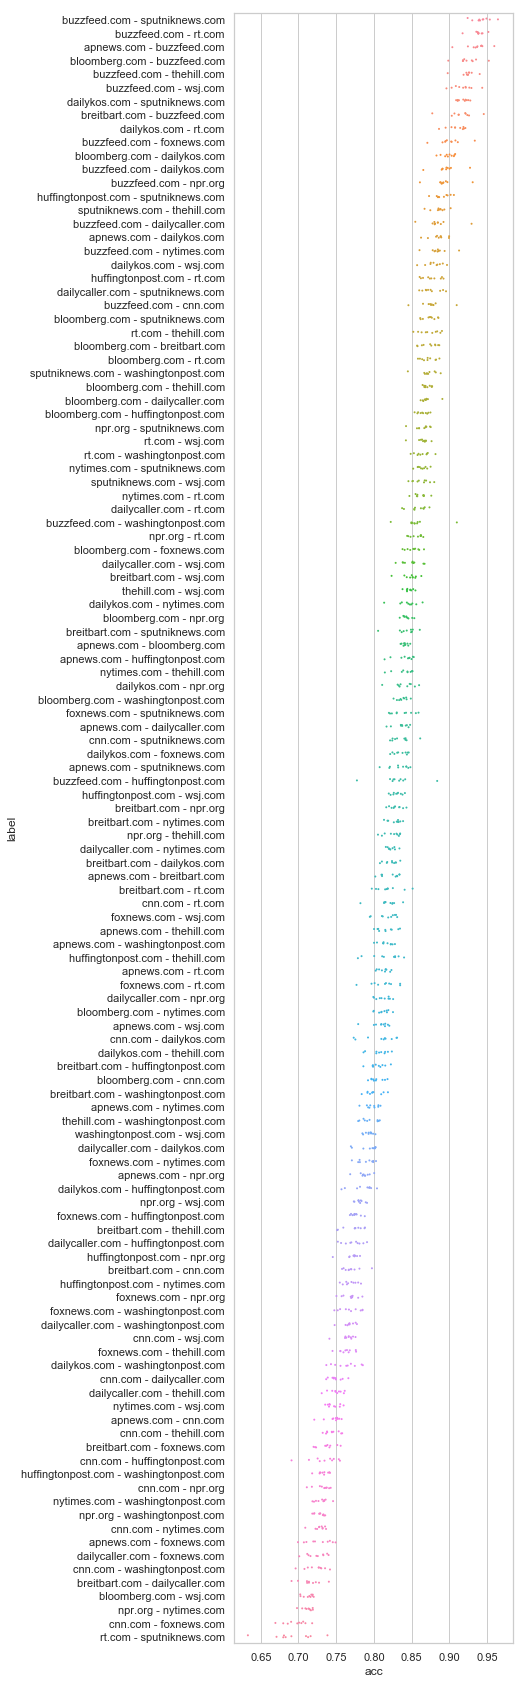

In [27]:
plt.figure(figsize=(5,30))
sns.stripplot(x='acc', y='label', data=score_df, order=order, s=2)

In [35]:
scaled_df = score_df.groupby(['d1', 'd2', 'label']).mean().reset_index()
scaled_df['score'] = preprocessing.scale(scaled_df.acc)

In [36]:
scaled_df.sort_values('score', ascending=False, inplace=True)

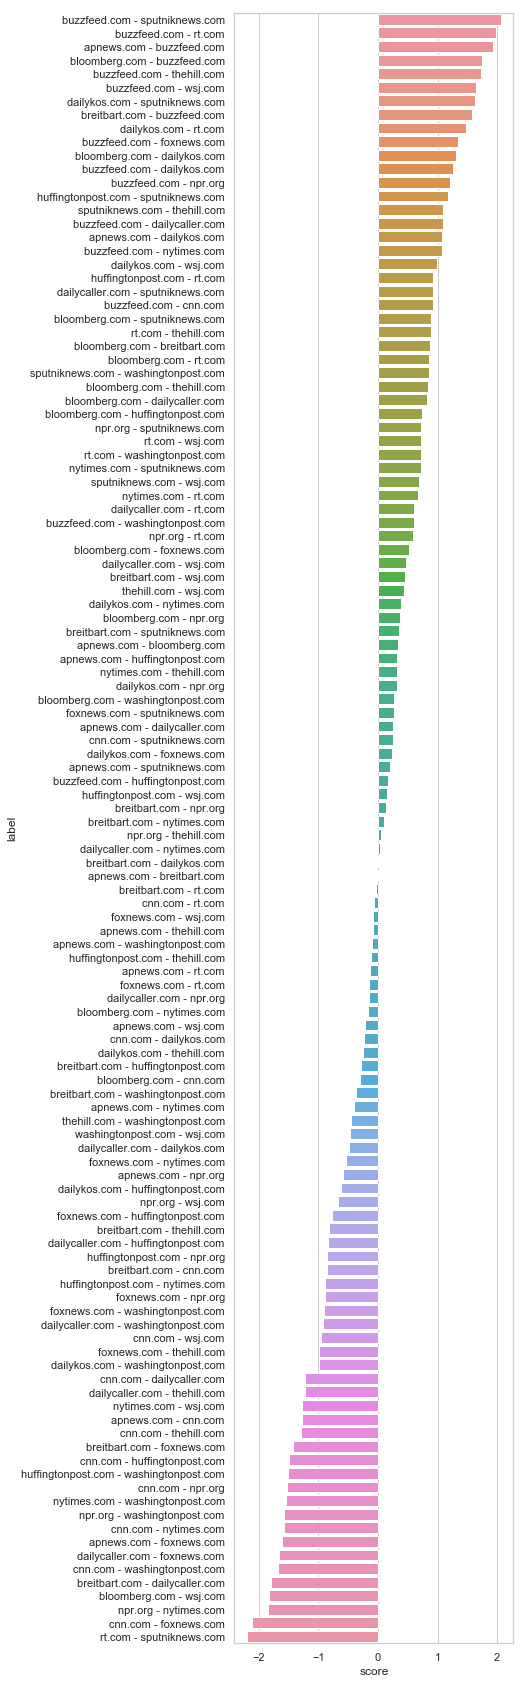

In [38]:
plt.figure(figsize=(5,30))
sns.barplot(x='score', y='label', data=scaled_df)

In [39]:
scaled_df.to_json('data/headline-graph-ab-clf.json', orient='records', lines=True)